### Este script permite calibrar una cámara a partir de una colección de imágenes tomadas de un tablero de calibración de patrón de ajedrez de 9x6 (tamaño del lado del cuadrado 2.5cm)


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
#from google.colab.patches import cv2_imshow

calib_img_path = "./calibration_images" # Set to path with calibration images

# Define the size of the checkerboard
checkerboard_size = (9, 6)  # Change this to match your checkerboard

square_size = 2.5 # in cm

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
objp *= square_size

gray = None

def detect_points_in_frame(frame, fn, objpoints, imgpoints):
    # Convert to grayscale
    global gray
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

    # If found, add object points, image points (after refining them)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)
    else:
        print(f"Warning: no corners detected in file {fn}\n")


def detect_points_using_imgs(path, objpoints, imgpoints):
    for filename in os.listdir(path):
        if filename.lower().endswith('.png'):
            frame = cv2.imread(os.path.join(path, filename), cv2.IMREAD_UNCHANGED)
            detect_points_in_frame(frame, filename, objpoints, imgpoints)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

detect_points_using_imgs(calib_img_path, objpoints, imgpoints)

# Actually calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Print calibration results
print("Camera matrix:")
print(mtx)
print("\nDistortion coefficients:")
print(dist)


Camera matrix:
[[1.23172586e+03 0.00000000e+00 6.26321462e+02]
 [0.00000000e+00 1.23062439e+03 3.74670201e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients:
[[-1.85318219e-02  1.15177100e+00 -1.46622290e-04  1.33195459e-03
  -3.63515065e+00]]


In [3]:
def calculate_distortion_error(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    """Calculates the average difference between detected points in the image and the same points undistorted"""
    total_error = 0
    total_points = 0

    for i in range(len(objpoints)):
        # Undistort the detected image points
        imgpoints_undistorted = cv2.undistortPoints(np.array(imgpoints[i], dtype=np.float32), mtx, dist, P=mtx)
        imgpoints_undistorted = np.array(imgpoints_undistorted).reshape(-1, 2)
        
        # Convert original detected points to the same shape
        imgpoints_original = np.array(imgpoints[i], dtype=np.float32).reshape(-1, 2)
        
        # Compute the error (Euclidean distance between detected and undistorted points)
        error = np.sqrt(np.sum((imgpoints_original - imgpoints_undistorted) ** 2, axis=1))
        total_error += np.sum(error)
        total_points += len(imgpoints[i])
        
    average_error = total_error / total_points
    return average_error


re = calculate_distortion_error(objpoints, imgpoints, rvecs, tvecs, mtx, dist)
print(f"Distortion error: {re:.4f} pixels")

Distortion error: 0.4255 pixels


Let's estimate the real-world error made in cm on the voxels that are the farthest from the camera (about ~104 cm)

Estimemos a continuación el error de mundo real cometido en cm sobre los vóxels que están lo más alejados de la cámara (unos ~104 cm)

In [4]:
f = 1314
Z = 104
scaling_factor = Z/f
print(f"Scaling factor: {scaling_factor:.4f} cm/pixel")
print(f"Error: {re*scaling_factor:.4f} cm")
print(f"Percent error for a voxel of side 2cm: {re*scaling_factor*100/2:.2f}% error")

Scaling factor: 0.0791 cm/pixel
Error: 0.0337 cm
Percent error for a voxel of side 2cm: 1.68% error


In [120]:
def plot_distorted_vs_undistorted(imgpoints, index, mtx, dist, ax, legend=True):
    points_distorted = imgpoints[index]
    points_undistorted = cv2.undistortPoints(points_distorted, mtx, dist, P=mtx)

    X = []
    Y = []
    # Draw the original distorted points (red)
    for point in points_distorted:
        x, y = point.ravel()
        X.append(x)
        Y.append(y)
    ax.scatter(X, Y, color='red', marker='o', label="Original")
        
    X = []
    Y = []
    # Draw the undistorted points (green)
    for point in points_undistorted:
        x, y = point.ravel()
        X.append(x)
        Y.append(y)
    ax.scatter(X, Y, color='cyan', marker='o', label="Undistorted")
    if legend:
        ax.legend(loc='upper left', bbox_to_anchor=(-0.00, 1.25))

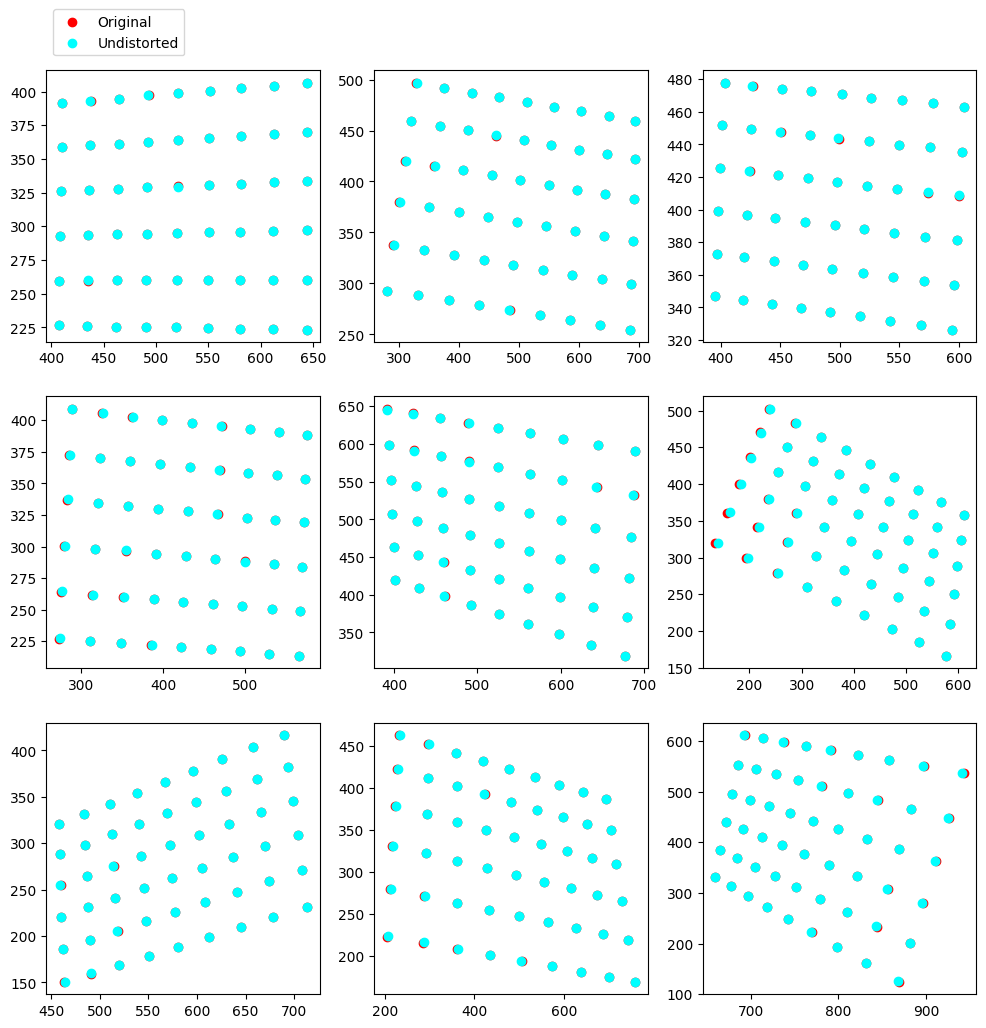

In [121]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

offset = 8
for i in range(3):
    for j in range(3):
        plot_distorted_vs_undistorted(imgpoints, offset + i*6+j*2, mtx, dist, ax[i,j], legend=i==0 and j==0)
plt.savefig("./distort-undistort.png")

Let us now serialize these parameters into a binary file for easy recovery at a later stage without the need to undergo the calibration process again

Serialicemos los parámetros a un archivo binario para poder recuperarlos rápidamente sin tener que volver a pasar por el proceso de calibración

In [122]:
# Save calibration to file

import pickle

# Create a dictionary to hold the parameters
parameters = {
    'camera_matrix': mtx,
    'distortion_coefficients': dist
}

# File path to save the JSON file
file_path = 'camera_parameters.bin'

# Write the parameters to the JSON file
with open(file_path, 'wb') as file:
    pickle.dump(parameters, file)

print(f"Camera parameters saved to {file_path}")

Camera parameters saved to camera_parameters.bin


Let's read them back and check the save/load preserves the information OK:

Leamos estos parámetros del archivo y comprobemos que el proceso de guardado/cargado respeta la información:

In [126]:
def read_camera_parameters_from_file(fn):
  with open(fn, "rb") as file:
    result = pickle.load(file)
  return result

In [127]:
read_camera_parameters_from_file("./camera_parameters.bin")

{'camera_matrix': array([[1.23172586e+03, 0.00000000e+00, 6.26321462e+02],
        [0.00000000e+00, 1.23062439e+03, 3.74670201e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'distortion_coefficients': array([[-1.85318219e-02,  1.15177100e+00, -1.46622290e-04,
          1.33195459e-03, -3.63515065e+00]])}